In [ ]:
!pip uninstall -y scikit-learn imbalanced-learn umap-learn protobuf xgboost lightgbm catboost


Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2
Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0
Found existing installation: xgboost 2.0.3
Uninstalling xgboost-2.0.3:
  Successfully uninstalled xgboost-2.0.3
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0
Found existing installation: catboost 1.2.8
Uninstalling catboost-1.2.8:
  Successfully uninstalled catboost-1.2.8


In [ ]:
!pip install --no-cache-dir \
  scikit-learn==1.4.2 \
  imbalanced-learn==0.12.3 \
  protobuf==4.25.3 \
  xgboost==2.0.3 \
  lightgbm==4.3.0 \
  catboost==1.2.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 183.2 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 293.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 302.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 258.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 255.8 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.3 which is incompatible.
ray 2.51.1 r

In [ ]:
import sklearn, xgboost, lightgbm, catboost, imblearn
import google.protobuf as protobuf

print("sklearn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)
print("xgboost:", xgboost.__version__)
print("lightgbm:", lightgbm.__version__)
print("catboost:", catboost.__version__)
print("protobuf:", protobuf.__version__)


sklearn: 1.4.2
imblearn: 0.12.3
xgboost: 2.0.3
lightgbm: 4.3.0
catboost: 1.2.5
protobuf: 4.25.3


In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}

In [4]:
# Check skewness of each column (excluding target if needed)
import pandas as pd
skewness = df.drop('Potability', axis=1).skew()

print("📌 Skewness of Features:\n")
for col, value in skewness.items():
    print(f"{col}: {value:.4f}")


📌 Skewness of Features:

ph: 0.0256
Hardness: -0.0393
Solids: 0.6216
Chloramines: -0.0121
Sulfate: -0.0359
Conductivity: 0.2645
Organic_carbon: 0.0255
Trihalomethanes: -0.0830
Turbidity: -0.0078


In [7]:
import numpy as np
standards = {
    "pH": 8.5,
    "Hardness": 300,
    "Solids": 500,
    "Chloramines": 3.0,
    "Sulfate": 250,
    "Conductivity": None,
    "Organic_carbon": None,
    "Turbidity": 5,
    "Trihalomethanes": 0.1
    }
valid_params = {k: v for k, v in standards.items() if v is not None}
log_inv = {k: np.log(1 + 1/v) for k, v in valid_params.items()}
denom = sum(log_inv.values())
weights_balanced = {k: log_inv[k] / denom for k in log_inv}
print("Balanced (Log-Scaled) WQI Weights:\n")
for k, v in weights_balanced.items():
    print(f"{k}: {v:.6f}")


Balanced (Log-Scaled) WQI Weights:

pH: 0.184407
Hardness: 0.008269
Solids: 0.003313
Chloramines: 0.476964
Sulfate: 0.008269
Turbidity: 0.302281
Trihalomethanes_total: 0.016497


In [ ]:
# ============================================================
# WATER POTABILITY PREPROCESSING PIPELINE WITH STANDARD WQI
# ============================================================

import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from imblearn.combine import SMOTETomek
from sklearn.utils import resample

# ============================================================
# 1️⃣ Load Dataset
# ============================================================
df = pd.read_csv("/kaggle/input/water-potability-project/water_potability.csv")

# ============================================================
# 2️⃣ Handle Missing Values (KNN Imputer)
# ============================================================
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])

# ============================================================
# 3️⃣ Outlier Treatment (IQR Method)
# ============================================================
def remove_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return np.clip(col, lower, upper)

for col in df.columns[:-1]:  # except Potability
    df[col] = remove_outliers(df[col])

# ============================================================
# 4️⃣ Additional Outlier Removal (Isolation Forest)
# ============================================================
iso = IsolationForest(contamination=0.03, random_state=42)
mask = iso.fit_predict(df.drop("Potability", axis=1)) == 1
df = df[mask].reset_index(drop=True)

# ============================================================
# 5️⃣ Handle Skewness (Log Transform)
# ============================================================
skewed_cols = ['Solids', 'Trihalomethanes']
for col in skewed_cols:
    df[col] = np.log1p(df[col])  # log(1 + x)

# ============================================================
# 6️⃣ ENGINEERED FEATURES
# ============================================================
df['Water_Acidity'] = abs(df['ph'] - 7)
df['Mineral_Load'] = df['Hardness'] + df['Solids'] + df['Sulfate']
df['Organic_Risk'] = df['Organic_carbon'] + df['Trihalomethanes']
df['Disinfection_Strength'] = df['Chloramines'] + df['Turbidity']
df['Purity_Score'] = 1 / (df['Solids'] + 1)

# ============================================================
# 7️⃣ WQI CALCULATION (Standard Method)
# ============================================================
STANDARDS = {
    "ph": 8.5,
    "Hardness": 300,
    "Solids": 500,
    "Chloramines": 3.0,
    "Sulfate": 250,
    "Turbidity": 5,
    "Trihalomethanes": 0.1
}

IDEAL = {
    "ph": 7,
    "Hardness": 0,
    "Solids": 0,
    "Chloramines": 0,
    "Sulfate": 0,
    "Turbidity": 0,
    "Trihalomethanes": 0
}

WEIGHTS = {
    "ph": 0.184407,
    "Hardness": 0.008269,
    "Solids": 0.003313,
    "Chloramines": 0.476964,
    "Sulfate": 0.008269,
    "Turbidity": 0.302281,
    "Trihalomethanes": 0.016497
}

def compute_Qi(param, value):
    Si = STANDARDS[param]
    Ii = IDEAL[param]
    if pd.isna(value):
        return np.nan
    Qi = ((value - Ii) / (Si - Ii)) * 100
    return max(Qi, 0)

def compute_WQI(row):
    return sum(compute_Qi(param, row[param]) * WEIGHTS[param] for param in WEIGHTS)

def classify_WQI(wqi):
    if wqi <= 50:
        return "Excellent"
    elif wqi <= 100:
        return "Good"
    elif wqi <= 200:
        return "Poor"
    elif wqi <= 300:
        return "Very Poor"
    else:
        return "Unsuitable for Drinking"

df["WQI"] = df.apply(compute_WQI, axis=1)
df["WQI_Class"] = df["WQI"].apply(classify_WQI)

print("WQI Summary:\n", df["WQI"].describe())
print("\nWQI Class Distribution:\n", df["WQI_Class"].value_counts())

# ============================================================
# 8️⃣ PREP FOR BALANCING (Split X and y)
# ============================================================
X = df.drop(columns=['Potability', 'WQI_Class'])
y = df['Potability']

# ============================================================
# 9️⃣ BALANCING METHOD 1 — OVERSAMPLING
# ============================================================
majority = df[df.Potability == 0]
minority = df[df.Potability == 1]

minority_up = resample(
    minority, replace=True, n_samples=len(majority), random_state=42
)

df_oversampled = pd.concat([majority, minority_up])
X_over = df_oversampled.drop(columns=['Potability', 'WQI_Class'])
y_over = df_oversampled["Potability"]

# ============================================================
# 🔟 BALANCING METHOD 2 — SMOTE + TOMEK LINKS
# ============================================================
smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X, y)

# ============================================================
# 1️⃣1️⃣ SCALING
# ============================================================
scaler = StandardScaler()
X_over_scaled = scaler.fit_transform(X_over)
X_smt_scaled = scaler.fit_transform(X_smt)

# ============================================================
# 1️⃣2️⃣ TRAIN–TEST SPLIT
# ============================================================
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over_scaled, y_over, test_size=0.2, random_state=42, stratify=y_over
)

X_train_smt, X_test_smt, y_train_smt, y_test_smt = train_test_split(
    X_smt_scaled, y_smt, test_size=0.2, random_state=42, stratify=y_smt
)

print("Preprocessing Completed Successfully!")
print("Oversampled Train Shape:", X_train_over.shape)
print("SMOTE-Tomek Train Shape:", X_train_smt.shape)


WQI Summary:
 count    3177.000000
mean      215.090565
std        26.718594
min       135.668271
25%       197.922726
50%       214.688433
75%       231.973836
max       312.549181
Name: WQI, dtype: float64

WQI Class Distribution:
 WQI_Class
Very Poor                  2286
Poor                        887
Unsuitable for Drinking       4
Name: count, dtype: int64
Preprocessing Completed Successfully!
Oversampled Train Shape: (3113, 15)
SMOTE-Tomek Train Shape: (2760, 15)


In [ ]:
# =========================================================
# ML TRAINING ON:
# 1️⃣ OVERSAMPLED DATASET
# 2️⃣ SMOTE-TOMEK DATASET
# Models:
# CatBoost, LightGBM, XGBoost, RandomForest,
# GradientBoosting, ExtraTrees, HistGradientBoosting, AdaBoost
# =========================================================

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.combine import SMOTETomek


# =============================================================
# FUNCTION: Train + Evaluate a model
# =============================================================
def train_and_evaluate(model, params, X_train, X_test, y_train, y_test):

    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)
    probs = best_model.predict_proba(X_test)[:, 1]

    return {
        "best_params": grid.best_params_,
        "accuracy": accuracy_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, probs)
    }


# =============================================================
# DICTIONARY OF ALL MODELS + PARAMETERS
# =============================================================
models_params = {

    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [200, 300],
            "max_depth": [None, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1,2,4],
            "class_weight": ["balanced"],
            "max_features": ["sqrt", "log2"]
        }
    },

    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {

            "n_estimators": [200, 300],
            "learning_rate": [0.05, 0.1],
            "max_depth": [5, 7],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_leaf_nodes": [20, None],
            "subsample": [ 0.8, 1.0]
        }
    },

    "XGBoost": {
        "model": XGBClassifier(
            tree_method="hist",
            eval_metric='logloss'
        ),
        "params": {
            "n_estimators": [200, 350],
            "max_depth": [4, 6],
            "learning_rate": [0.03, 0.1],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "min_child_weight": [1, 3],
            "reg_lambda": [1.0, 2.0]
        }
    },

    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {
            "n_estimators": [200, 400],
            "learning_rate": [0.03, 0.1],
            "num_leaves": [31, 63],
            "min_child_samples": [20, 40],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    },

    "CatBoost": {
        "model": CatBoostClassifier(verbose=0),
        "params": {
            "depth": [4, 6],
            "learning_rate": [0.03, 0.1],
            "iterations": [300, 500],
            "l2_leaf_reg": [3, 6]
        }
    },

    "ExtraTrees": {
        "model": ExtraTreesClassifier(),
        "params": {
            "n_estimators": [200, 300, 500],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False],
            "max_features": ["sqrt", "log2", None]


        }
    },

   "AdaBoost": {
        "model": AdaBoostClassifier(
            estimator=DecisionTreeClassifier()
        ),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.05],
            "algorithm": ["SAMME.R"],
            "estimator__max_depth": [3,4,5],
            "estimator__min_samples_split": [2, 5]
        }
    },

    "HistGradientBoosting": {
        "model": HistGradientBoostingClassifier(),
        "params": {

               "max_iter": [200, 300, 500],
                "max_depth": [3, 5, 7],
                "learning_rate": [0.01, 0.05, 0.1],
                "min_samples_leaf": [20, 30, 50],
                "max_leaf_nodes": [20, 40, None],
                "l2_regularization": [0.0, 1.0]            # good bias/variance tradeoff

        }
    }

}

# Oversampling
X_os = X_train_over
y_os = y_train_over

# SMOTE-Tomek
X_sm = X_train_smt
y_sm = y_train_smt

# Oversampling test
X_test_set_os = X_test_over
y_test_set_os = y_test_over

# SMOTE-Tomek test
X_test_set_sm = X_test_smt
y_test_set_sm = y_test_smt


# =============================================================
# 1️⃣ TRAIN USING OVERSAMPLED DATASET
# =============================================================
print("\n============================")
print(" TRAINING ON OVERSAMPLING ")
print("============================")

# Already completed models
results_oversampling = {}


# List of models already completed
completed_models = []


# Train remaining models only
for model_name, mp in models_params.items():
    if model_name in completed_models:
        print(f"✅ Skipping {model_name}, already trained.")
        continue

    model = mp["model"]
    params = mp["params"]
    print(f"\n🔵 Training {model_name} ...")
    results_oversampling[model_name] = train_and_evaluate(
        model, params, X_os, X_test_set_os, y_os, y_test_set_os
    )
    print(results_oversampling[model_name])



# =============================================================
# 2️⃣ TRAIN USING SMOTE-TOMEK
# =============================================================
print("\n============================")
print(" TRAINING ON SMOTE-TOMEK ")
print("============================")

smt = SMOTETomek(random_state=42)
X_sm, y_sm = smt.fit_resample(X_os, y_os)

results_smote = {}

for model_name, mp in models_params.items():
    model = mp["model"]
    params = mp["params"]
    print(f"\n🟣 Training {model_name} ...")
    results_smote[model_name] = train_and_evaluate(
        model, params, X_sm, X_test_set_sm, y_sm, y_test_set_sm
    )
    print(results_smote[model_name])


# =============================================================
# FINAL OUTPUT
# =============================================================
print("\n\n================ RESULTS ================")

print("\n📌 Oversampling Results:")
for m in results_oversampling:
    print(m, "→", results_oversampling[m])

print("\n📌 SMOTE-Tomek Results:")
for m in results_smote:
    print(m, "→", results_smote[m])



 TRAINING ON OVERSAMPLING 

🔵 Training RandomForest ...
{'best_params': {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, 'accuracy': 0.8395378690629012, 'f1': 0.8370273794002607, 'roc_auc': 0.9124052468525476}

🔵 Training GradientBoosting ...
{'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}, 'accuracy': 0.8228498074454429, 'f1': 0.8248730964467005, 'roc_auc': 0.9027750313097357}

🔵 Training XGBoost ...
{'best_params': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 350, 'reg_lambda': 1.0, 'subsample': 0.7}, 'accuracy': 0.8112965340179717, 'f1': 0.8187422934648582, 'roc_auc': 0.8930327598708061}

🔵 Training LightGBM ...
[LightGBM] [Info] Number of positive: 1038, number of negative: 1037
[LightGBM] [Info] Auto-choosing col-wise

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

{'best_params': {'algorithm': 'SAMME.R', 'estimator__max_depth': 5, 'estimator__min_samples_split': 2, 'learning_rate': 0.05, 'n_estimators': 200}, 'accuracy': 0.7650834403080873, 'f1': 0.7726708074534161, 'roc_auc': 0.8144683936457716}

🔵 Training HistGradientBoosting ...
{'best_params': {'l2_regularization': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 500, 'max_leaf_nodes': None, 'min_samples_leaf': 20}, 'accuracy': 0.8112965340179717, 'f1': 0.8178438661710037, 'roc_auc': 0.8972579263067695}

 TRAINING ON SMOTE-TOMEK 

🟣 Training RandomForest ...
{'best_params': {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, 'accuracy': 0.8449275362318841, 'f1': 0.8254486133768353, 'roc_auc': 0.9520730938878387}

🟣 Training GradientBoosting ...
{'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'subsamp

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

{'best_params': {'algorithm': 'SAMME.R', 'estimator__max_depth': 5, 'estimator__min_samples_split': 2, 'learning_rate': 0.05, 'n_estimators': 200}, 'accuracy': 0.7768115942028986, 'f1': 0.7433333333333333, 'roc_auc': 0.8407561436672967}

🟣 Training HistGradientBoosting ...
{'best_params': {'l2_regularization': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'max_iter': 500, 'max_leaf_nodes': 40, 'min_samples_leaf': 20}, 'accuracy': 0.8492753623188406, 'f1': 0.8333333333333334, 'roc_auc': 0.9256626759084227}


================ RESULTS ================

📌 Oversampling Results:
RandomForest → {'best_params': {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, 'accuracy': 0.8395378690629012, 'f1': 0.8370273794002607, 'roc_auc': 0.9124052468525476}
GradientBoosting → {'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 

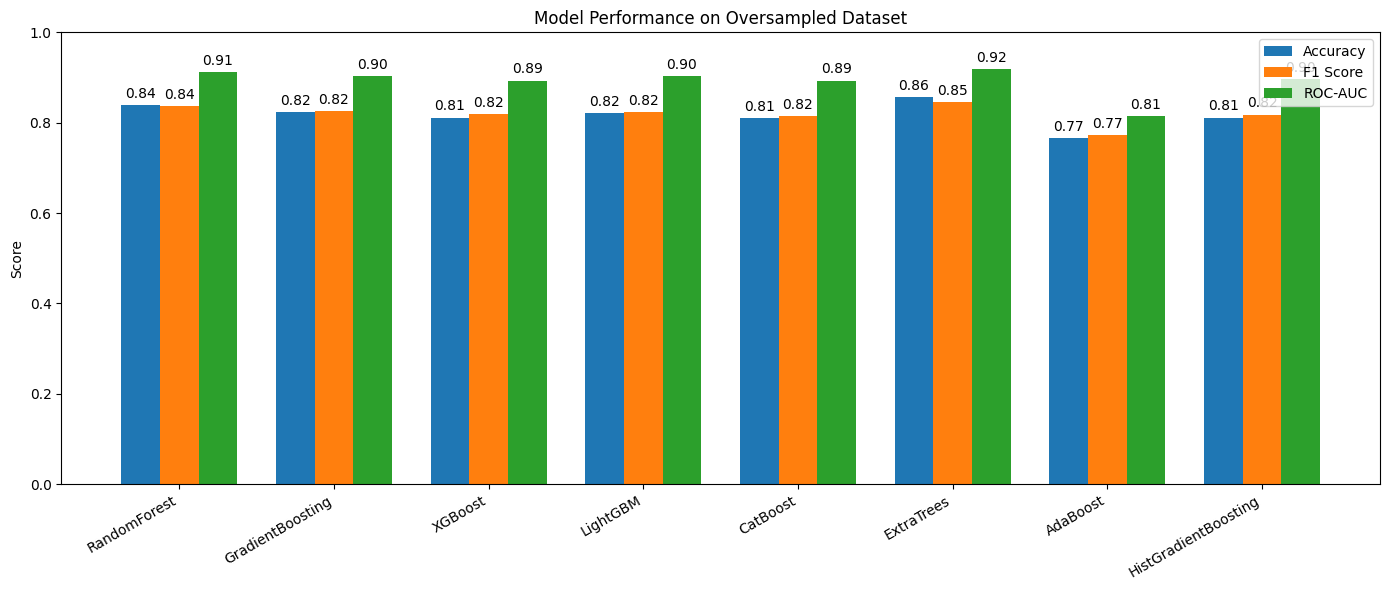


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

results_oversampling = {
    "RandomForest": {'accuracy': 0.8395, 'f1': 0.8370, 'roc_auc': 0.9124},
    "GradientBoosting": {'accuracy': 0.8228, 'f1': 0.8249, 'roc_auc': 0.9028},
    "XGBoost": {'accuracy': 0.8113, 'f1': 0.8187, 'roc_auc': 0.8930},
    "LightGBM": {'accuracy': 0.8216, 'f1': 0.8238, 'roc_auc': 0.9031},
    "CatBoost": {'accuracy': 0.8100, 'f1': 0.8155, 'roc_auc': 0.8932},
    "ExtraTrees": {'accuracy': 0.8575, 'f1': 0.8460, 'roc_auc': 0.9189},
    "AdaBoost": {'accuracy': 0.7651, 'f1': 0.7727, 'roc_auc': 0.8145},
    "HistGradientBoosting": {'accuracy': 0.8113, 'f1': 0.8178, 'roc_auc': 0.8973}
}

models = list(results_oversampling.keys())
accuracy = [results_oversampling[m]['accuracy'] for m in models]
f1 = [results_oversampling[m]['f1'] for m in models]
roc_auc = [results_oversampling[m]['roc_auc'] for m in models]

x = np.arange(len(models))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x, f1, width, label='F1 Score')
rects3 = ax.bar(x + width, roc_auc, width, label='ROC-AUC')

# Labels, title, ticks
ax.set_ylabel('Score')
ax.set_title('Model Performance on Oversampled Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right')
ax.set_ylim(0, 1)
ax.legend()

# Add values on top of bars
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


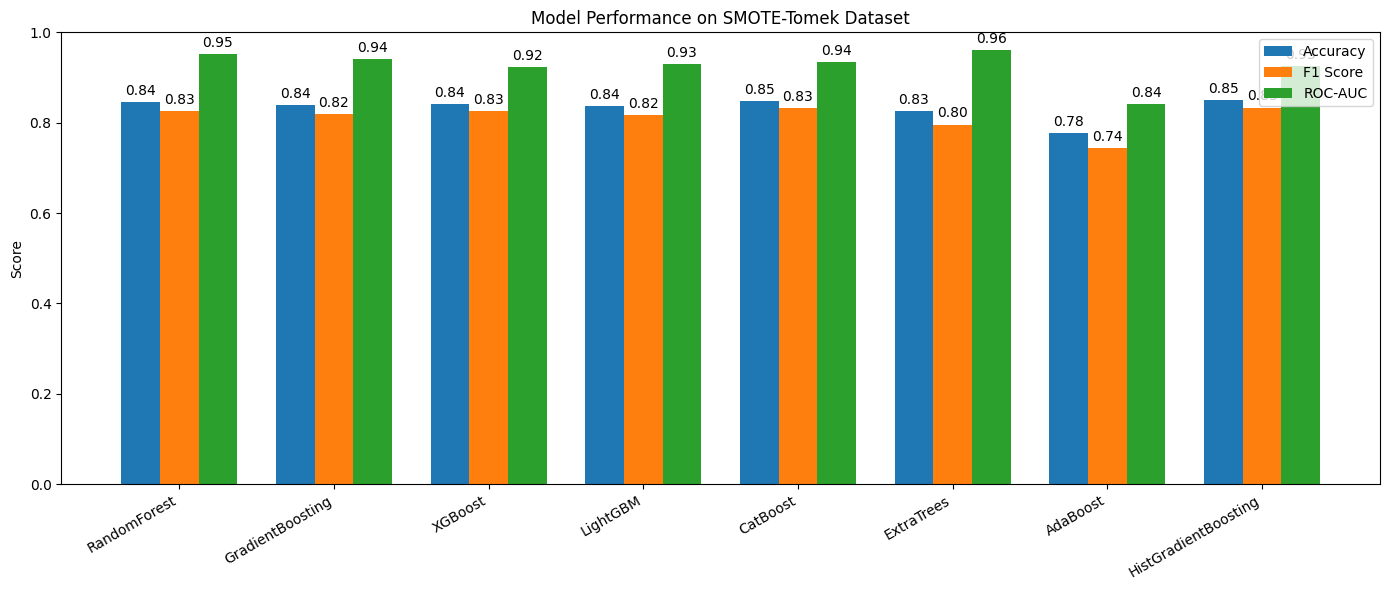

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# SMOTE-Tomek results
results_smote = {
    "RandomForest": {'accuracy': 0.8449, 'f1': 0.8254, 'roc_auc': 0.9521},
    "GradientBoosting": {'accuracy': 0.8391, 'f1': 0.8183, 'roc_auc': 0.9414},
    "XGBoost": {'accuracy': 0.8406, 'f1': 0.8254, 'roc_auc': 0.9224},
    "LightGBM": {'accuracy': 0.8362, 'f1': 0.8169, 'roc_auc': 0.9294},
    "CatBoost": {'accuracy': 0.8478, 'f1': 0.8325, 'roc_auc': 0.9350},
    "ExtraTrees": {'accuracy': 0.8261, 'f1': 0.7959, 'roc_auc': 0.9614},
    "AdaBoost": {'accuracy': 0.7768, 'f1': 0.7433, 'roc_auc': 0.8408},
    "HistGradientBoosting": {'accuracy': 0.8493, 'f1': 0.8333, 'roc_auc': 0.9257}
}

models = list(results_smote.keys())
accuracy = [results_smote[m]['accuracy'] for m in models]
f1 = [results_smote[m]['f1'] for m in models]
roc_auc = [results_smote[m]['roc_auc'] for m in models]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x, f1, width, label='F1 Score')
rects3 = ax.bar(x + width, roc_auc, width, label='ROC-AUC')

ax.set_ylabel('Score')
ax.set_title('Model Performance on SMOTE-Tomek Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right')
ax.set_ylim(0, 1)
ax.legend()

# Add values on top of bars
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()



🔹 Training and testing ExtraTrees ...


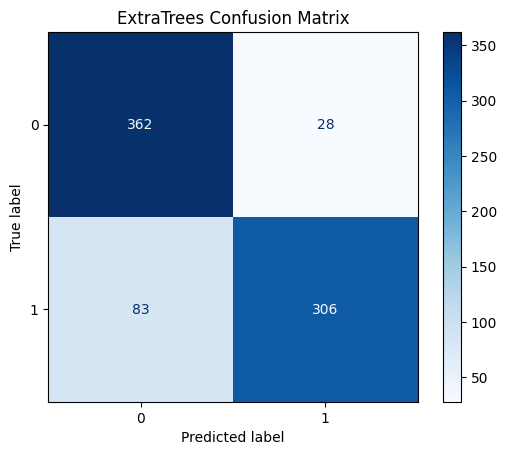


🔹 Training and testing RandomForest ...


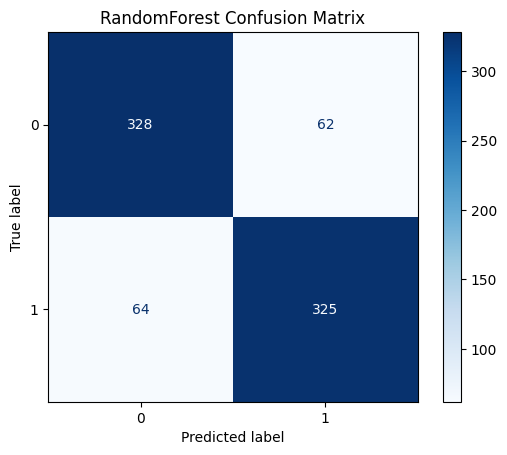


🔹 Training and testing GradientBoosting ...


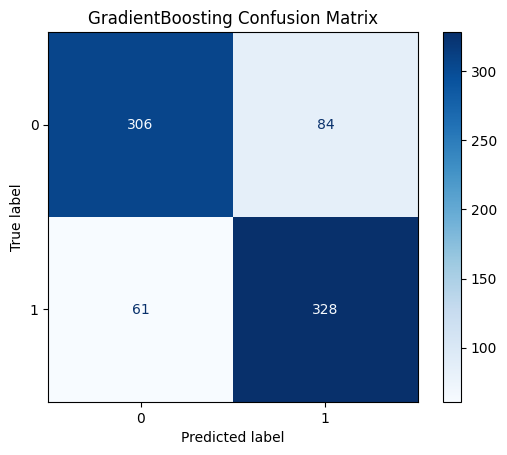


🔹 Training and testing LightGBM ...
[LightGBM] [Info] Number of positive: 1557, number of negative: 1556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 3113, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500161 -> initscore=0.000642
[LightGBM] [Info] Start training from score 0.000642


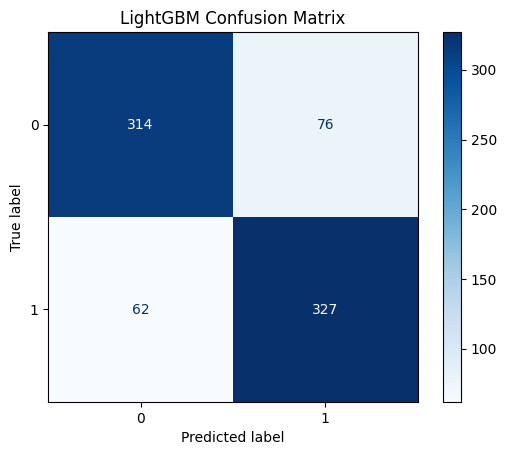


✅ Top 4 Model Results:
                  accuracy  f1_score   roc_auc        confusion_matrix
ExtraTrees         0.85751  0.846473  0.919214  [[362, 28], [83, 306]]
RandomForest      0.838254  0.837629  0.913635  [[328, 62], [64, 325]]
GradientBoosting  0.813864  0.818976  0.897291  [[306, 84], [61, 328]]
LightGBM           0.82285  0.825758   0.90207  [[314, 76], [62, 327]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Top 4 models based on oversampling accuracy
top4_models = {
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2,
        min_samples_leaf=1, bootstrap=False, max_features='sqrt',
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=None, min_samples_split=2,
        min_samples_leaf=1, class_weight='balanced', max_features='log2',
        random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.1, max_depth=7, max_leaf_nodes=None,
        min_samples_leaf=2, min_samples_split=5, n_estimators=200,
        subsample=0.8, random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=400, learning_rate=0.03, num_leaves=63,
        min_child_samples=20, subsample=0.8, colsample_bytree=1.0,
        random_state=42
    )
}

# Oversampled train and test data
X_train = X_os
y_train = y_os
X_test = X_test_set_os
y_test = y_test_set_os

# Dictionary to store results
top4_results = {}

for name, model in top4_models.items():
    print(f"\n🔹 Training and testing {name} ...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs) if probs is not None else None
    cm = confusion_matrix(y_test, preds)

    # Save results
    top4_results[name] = {
        "accuracy": acc,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# Display all results
results_df = pd.DataFrame(top4_results).T
print("\n✅ Top 4 Model Results:")
print(results_df)


In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier  # correct import
import warnings
warnings.filterwarnings("ignore")


# -------------------------------
# BASE MODELS (Top 4)
# -------------------------------

et = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=False
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="log2",
    class_weight="balanced",
    random_state=42
)

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    max_leaf_nodes=None,
    subsample=0.8,
    random_state=42
)

lgb = LGBMClassifier(
    n_estimators=400,
    num_leaves=63,
    learning_rate=0.1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# -------------------------------
# META LEARNER
# -------------------------------

meta_lr = LogisticRegression(
    solver='lbfgs',
    C=0.1,
    max_iter=1000,
    penalty='l2',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# -------------------------------
# STACKING ENSEMBLE
# -------------------------------

estimators = [
    ("et", et),
    ("rf", rf),
    ("gb", gb),
    ("lgb", lgb)
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_lr,
    stack_method="predict_proba",
    n_jobs=-1,
    cv=5,
    passthrough=False
)

# -------------------------------
# TRAIN STACKING MODEL
# -------------------------------

print("🔵 Training Stacking Ensemble (Top 4 Models)...")
stack_model.fit(X_train_over, y_train_over)

# -------------------------------
# EVALUATE
# -------------------------------

y_pred = stack_model.predict(X_test_over)
y_prob = stack_model.predict_proba(X_test_over)[:, 1]

acc = accuracy_score(y_test_over, y_pred)
f1 = f1_score(y_test_over, y_pred)
auc = roc_auc_score(y_test_over, y_prob)

print("\n✅ FINAL STACKING ENSEMBLE RESULTS (Top 4 Models)")
print("Accuracy:", acc)
print("F1 Score:", f1)
print("ROC-AUC:", auc)


🔵 Training Stacking Ensemble (Top 4 Models)...
[LightGBM] [Info] Number of positive: 1246, number of negative: 1245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 2491, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500201 -> initscore=0.000803
[LightGBM] [Info] Start training from score 0.000803
[LightGBM] [Info] Number of positive: 1246, number of negative: 1244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Number of data points in the train set: 249

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# BASE MODELS (Top 4)
# -------------------------------

et = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=False,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="log2",
    class_weight="balanced",
    random_state=42
)

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    max_leaf_nodes=None,
    subsample=0.8,
    random_state=42
)

lgb = LGBMClassifier(
    n_estimators=400,
    num_leaves=63,
    learning_rate=0.1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# -------------------------------
# META LEARNER
# -------------------------------

meta_ridge = RidgeClassifier(alpha=1.0)

# -------------------------------
# STACKING ENSEMBLE
# -------------------------------

estimators_B = [
    ("et", et),
    ("rf", rf),
    ("gb", gb),
    ("lgb", lgb)
]

stack_B = StackingClassifier(
    estimators=estimators_B,
    final_estimator=meta_ridge,
    stack_method="predict",  # RidgeClassifier doesn't support predict_proba
    cv=5,
    n_jobs=-1
)

# -------------------------------
# TRAIN & EVALUATE
# -------------------------------

print("🔵 Training Stacking Ensemble (Top 4 Models with Ridge Meta-Learner)...")
stack_B.fit(X_train_over, y_train_over)
pred_B = stack_B.predict(X_test_over)

acc = accuracy_score(y_test_over, pred_B)
f1 = f1_score(y_test_over, pred_B)
# RidgeClassifier doesn't provide probabilities, so ROC-AUC can't be computed

print("\n✅ Stacking Ensemble Results (Ridge Meta-Learner)")
print("Accuracy:", acc)
print("F1 Score:", f1)


🔵 Training Stacking Ensemble (Top 4 Models with Ridge Meta-Learner)...
[LightGBM] [Info] Number of positive: 1246, number of negative: 1245
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Number of positive: 1246, number of negative: 1244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 2490, number of used features: 15
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006237 seconds.
Y

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# BASE MODELS (Top 4)
# -------------------------------
et = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=False
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="log2",
    class_weight="balanced"
)

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    max_leaf_nodes=None,
    subsample=0.8
)

lgb = LGBMClassifier(
    n_estimators=400,
    num_leaves=63,
    learning_rate=0.1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=1.0
)

# -------------------------------
# CALIBRATED META LEARNER
# -------------------------------
meta_ridge_raw = RidgeClassifier(alpha=0.5, class_weight="balanced")
meta_calibrated = CalibratedClassifierCV(meta_ridge_raw, method="sigmoid", cv=3)

# -------------------------------
# STACKING ENSEMBLE
# -------------------------------
estimators = [
    ("et", et),
    ("rf", rf),
    ("gb", gb),
    ("lgb", lgb)
]

stack_calib = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_calibrated,
    stack_method="predict_proba",
    n_jobs=-1,
    cv=5
)

# -------------------------------
# TRAIN STACKING MODEL
# -------------------------------
print("🔵 Training Stacking Ensemble (Top 4 Models with Calibrated Ridge Meta-Learner)...")
stack_calib.fit(X_train_over, y_train_over)

# -------------------------------
# EVALUATE
# -------------------------------
prob = stack_calib.predict_proba(X_test_over)[:,1]
pred = stack_calib.predict(X_test_over)

print("\n✅ FINAL STACKING ENSEMBLE RESULTS (Top 4 Models)")
print("Accuracy:", accuracy_score(y_test_over, pred))
print("F1 Score:", f1_score(y_test_over, pred))
print("ROC-AUC:", roc_auc_score(y_test_over, prob))


🔵 Training Stacking Ensemble (Top 4 Models with Calibrated Ridge Meta-Learner)...
[LightGBM] [Info] Number of positive: 1246, number of negative: 1245
[LightGBM] [Info] Number of positive: 1246, number of negative: 1244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 2491, number of used features: 15
[LightGBM] [Info] Number of pos

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# BASE MODELS (Top 4)
# -------------------------------

et = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=False,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="log2",
    class_weight="balanced",
    random_state=42
)

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    max_leaf_nodes=None,
    subsample=0.8,
    random_state=42
)

lgb = LGBMClassifier(
    n_estimators=400,
    num_leaves=63,
    learning_rate=0.1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# -------------------------------
# META LEARNER
# -------------------------------

meta_ridge = RidgeClassifier(alpha=1.0)

# -------------------------------
# STACKING ENSEMBLE
# -------------------------------

estimators_B = [
    ("et", et),
    ("rf", rf),
    ("gb", gb),
    ("lgb", lgb)
]

stack_B = StackingClassifier(
    estimators=estimators_B,
    final_estimator=meta_ridge,
    stack_method="predict",  # RidgeClassifier doesn't support predict_proba
    cv=5,
    n_jobs=-1
)

# -------------------------------
# TRAIN & EVALUATE
# -------------------------------

print("🔵 Training Stacking Ensemble (Top 4 Models with Ridge Meta-Learner)...")
stack_B.fit(X_train_over, y_train_over)
pred_B = stack_B.predict(X_test_over)

acc = accuracy_score(y_test_over, pred_B)
f1 = f1_score(y_test_over, pred_B)
# RidgeClassifier doesn't provide probabilities, so ROC-AUC can't be computed

print("\n✅ Stacking Ensemble Results (Ridge Meta-Learner)")
print("Accuracy:", acc)
print("F1 Score:", f1)


🔵 Training Stacking Ensemble (Top 4 Models with Ridge Meta-Learner)...
[LightGBM] [Info] Number of positive: 1246, number of negative: 1244
[LightGBM] [Info] Number of positive: 1246, number of negative: 1245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 2490, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500402 -> initscore=0.001606
[LightGBM] [Info] Start training from score 0.001606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Auto-choosing col-w

🔵 Training Base Stacking Model (Top 4 Models)...
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 2490, number of used features: 15
[LightGBM] [Info] Number of positive: 1246, number of negative: 1244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 2490, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500402 -> initscore=0.001606
[LightGBM] [Info] Start training from score 0.001606
[LightGBM] [Info] Number of positive: 1245, number of negative: 1245
[LightGBM] [Info] Auto-choosing col-

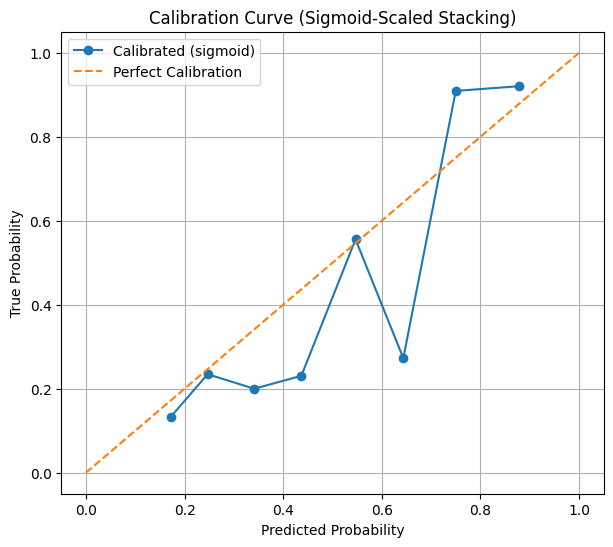

[LightGBM] [Info] Number of positive: 1557, number of negative: 1556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 3113, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500161 -> initscore=0.000642
[LightGBM] [Info] Start training from score 0.000642
[LightGBM] [Info] Number of positive: 1557, number of negative: 1556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 3113, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500161 -> initscore=0.000642
[LightGBM] [Info] Start training from score 0.000642
[LightGBM] [Info] Numb

In [ ]:
# ============================================
# 📌 Stacking + Calibration for Top 4 Models
# ============================================

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# BASE MODELS (Top 4)
# -------------------------------
et = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=False
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="log2",
    class_weight="balanced"
)

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    max_leaf_nodes=None,
    subsample=0.8
)

lgb = LGBMClassifier(
    n_estimators=400,
    num_leaves=63,
    learning_rate=0.1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=1.0
)

# -------------------------------
# META LEARNER
# -------------------------------
meta_ridge = RidgeClassifier(alpha=1.0)

# -------------------------------
# STACKING ENSEMBLE (Top 4)
# -------------------------------
estimators = [
    ("et", et),
    ("rf", rf),
    ("gb", gb),
    ("lgb", lgb)
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_ridge,
    stack_method="predict",  # Ridge does NOT support predict_proba directly
    cv=5,
    n_jobs=-1
)

# -------------------------------
# 1️⃣ Train Base Stacking Model
# -------------------------------
print("🔵 Training Base Stacking Model (Top 4 Models)...")
stack_model.fit(X_train_over, y_train_over)

pred_base = stack_model.predict(X_test_over)

print("\n🔷 Base Stacking (Before Calibration)")
print("Accuracy:", accuracy_score(y_test_over, pred_base))
print("F1 Score:", f1_score(y_test_over, pred_base))
# ROC-AUC not available yet (Ridge meta learner, need calibration for probabilities)

# -------------------------------
# 2️⃣ Calibrated Stacking Model
# -------------------------------
print("\n🔵 Applying Probability Calibration (Platt / Isotonic)...")

# Choose method: "sigmoid" (Platt) or "isotonic"
calibration_method = "sigmoid"  # "isotonic"

calibrated_model = CalibratedClassifierCV(
    estimator=stack_model,
    method=calibration_method,
    cv=5
)

calibrated_model.fit(X_train_over, y_train_over)

# Predictions & calibrated probabilities
pred_cal = calibrated_model.predict(X_test_over)
prob_cal = calibrated_model.predict_proba(X_test_over)[:, 1]

# -------------------------------
# 3️⃣ Evaluation Metrics
# -------------------------------
acc_cal = accuracy_score(y_test_over, pred_cal)
f1_cal = f1_score(y_test_over, pred_cal)
auc_cal = roc_auc_score(y_test_over, prob_cal)
brier = brier_score_loss(y_test_over, prob_cal)

print("\n🔶 Calibrated Stacking Model Results")
print("Accuracy:", acc_cal)
print("F1 Score:", f1_cal)
print("ROC-AUC:", auc_cal)
print("Brier Score:", brier)

# -------------------------------
# 4️⃣ Reliability / Calibration Curve
# -------------------------------
prob_true, prob_pred = calibration_curve(y_test_over, prob_cal, n_bins=10)

plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker='o', label=f'Calibrated ({calibration_method})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title(f"Calibration Curve ({calibration_method.capitalize()}-Scaled Stacking)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

X_train_df = pd.DataFrame(X_train_over, columns=X.columns)
X_test_df  = pd.DataFrame(X_test_over,  columns=X.columns)



🔍 Running FAST SHAP on Calibrated Stacking Model (Top 4 Models)...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP values computed successfully!


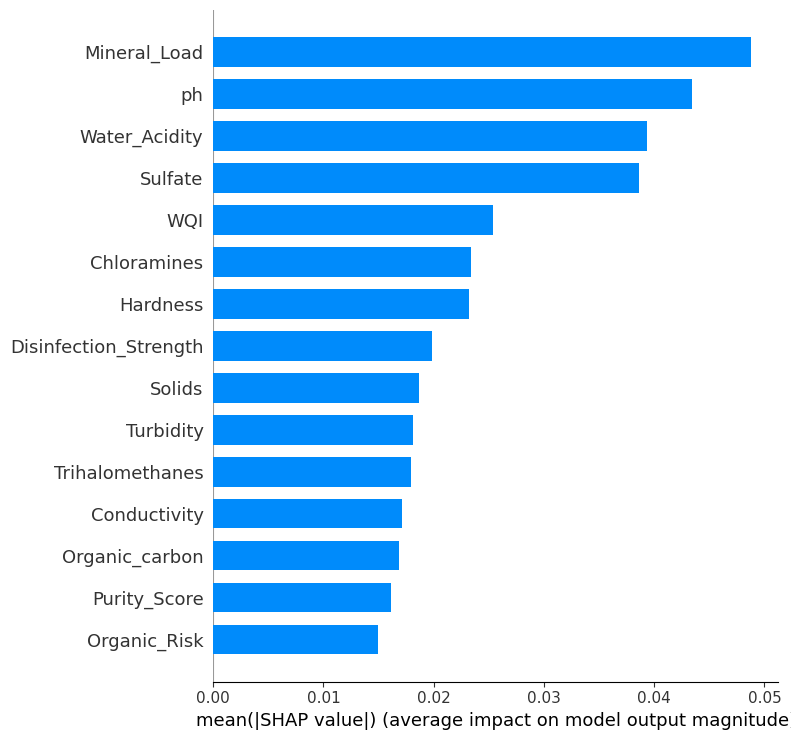

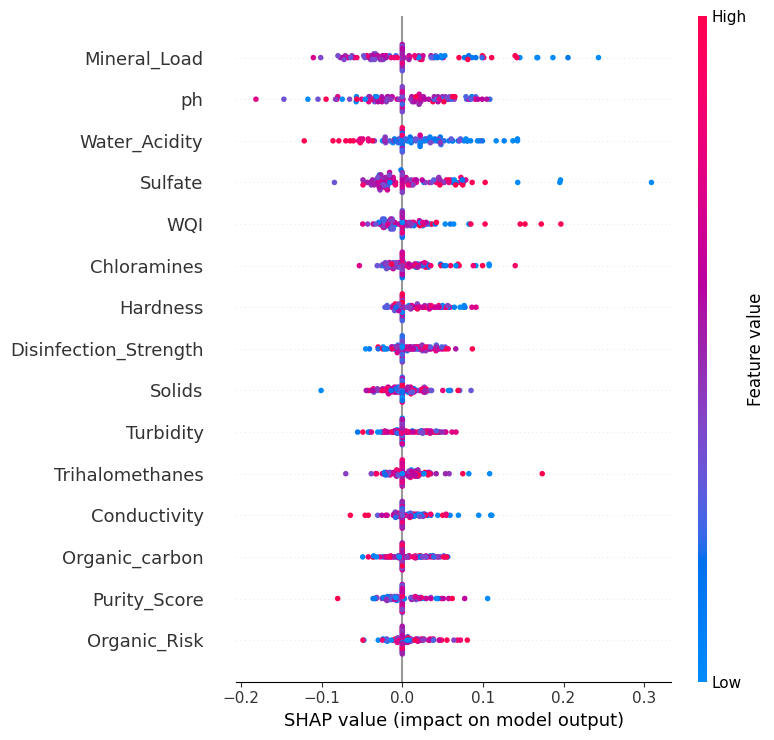

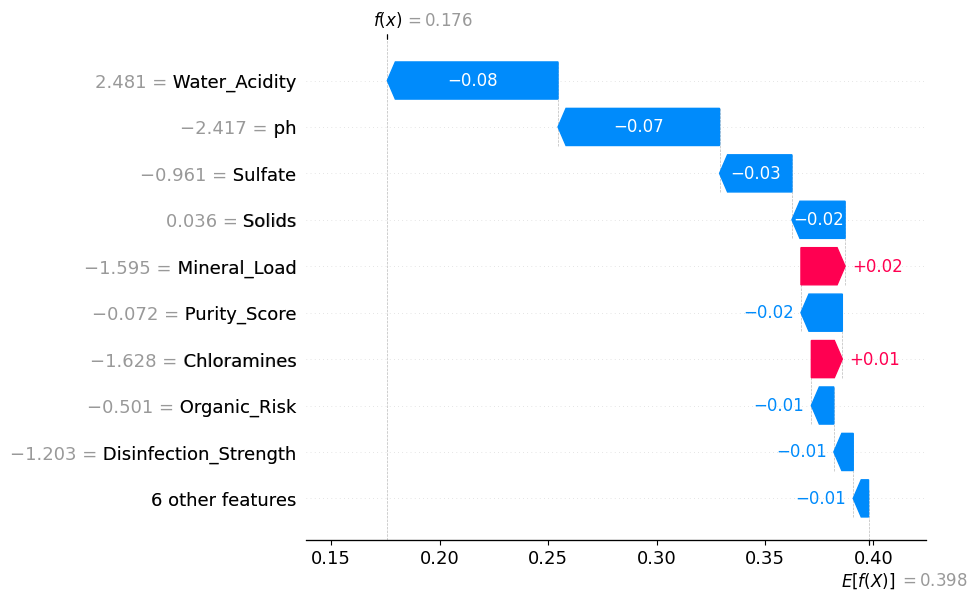


🔬 CHEMICAL INTERPRETATION OF THIS SAMPLE:

• Water_Acidity = 2.48 → ↓ decreases potability
• ph = -2.42 → ↓ decreases potability
• Sulfate = -0.96 → ↓ decreases potability
• Solids = 0.04 → ↓ decreases potability
• Mineral_Load = -1.59 → ↑ increases potability


In [ ]:
# ============================================
# 📌 FAST SHAP EXPLAINABILITY (Using Calibrated Stacking Model)
# ============================================

import shap
import numpy as np
import matplotlib.pyplot as plt

print("\n🔍 Running FAST SHAP on Calibrated Stacking Model (Top 4 Models)...")

# 1️⃣ Use calibrated stacking model
model = calibrated_model  # calibrated_model from probability calibration

# --------------------------------------------
# ⚡ FAST MODE FIXES
# --------------------------------------------
# Reduce background samples to speed up SHAP
X_background = shap.sample(X_train_df, 30, random_state=42)

# Use only a subset of test samples (first 50)
X_shap = X_test_df.iloc[:100]

# KernelExplainer works with predict_proba for probability output
explainer = shap.KernelExplainer(
    model.predict_proba,
    X_background,
)

# Compute SHAP values for class 1 (potable)
shap_values = explainer.shap_values(X_shap, nsamples=100)   # FAST!!
sv = shap_values[1]  # Class 1 contributions

print("✅ SHAP values computed successfully!")

# ============================================
# 📌 GLOBAL FEATURE IMPORTANCE (BAR PLOT)
# ============================================
shap.summary_plot(sv, X_shap, plot_type="bar")

# ============================================
# 📌 BEESWARM PLOT
# ============================================
shap.summary_plot(sv, X_shap)

# ============================================
# 📌 LOCAL SHAP EXPLANATION FOR ONE SAMPLE
# ============================================
sample_index = 10   # pick any test index
sample = X_shap.iloc[[sample_index]]

shap.waterfall_plot(
    shap.Explanation(
        values=sv[sample_index],
        base_values=explainer.expected_value[1],
        data=sample.values[0],
        feature_names=sample.columns
    )
)

# ============================================
# 📌 CHEMICAL INTERPRETATION (Top 5 features)
# ============================================
sample_row = X_shap.iloc[sample_index]
shap_contribs = sv[sample_index]

top_idx = np.argsort(-np.abs(shap_contribs))[:5]   # Top 5 influential features

print("\n🔬 CHEMICAL INTERPRETATION OF THIS SAMPLE:\n")


for i in top_idx:
    feature = sample_row.index[i]
    value = sample_row.iloc[i]
    contrib = shap_contribs[i]

    direction = "↑ increases potability" if contrib > 0 else "↓ decreases potability"
    print(f"• {feature} = {value:.2f} → {direction}")



🔍 Running FAST SHAP on Calibrated Stacking Model (Top 4 Models)...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP values computed successfully!


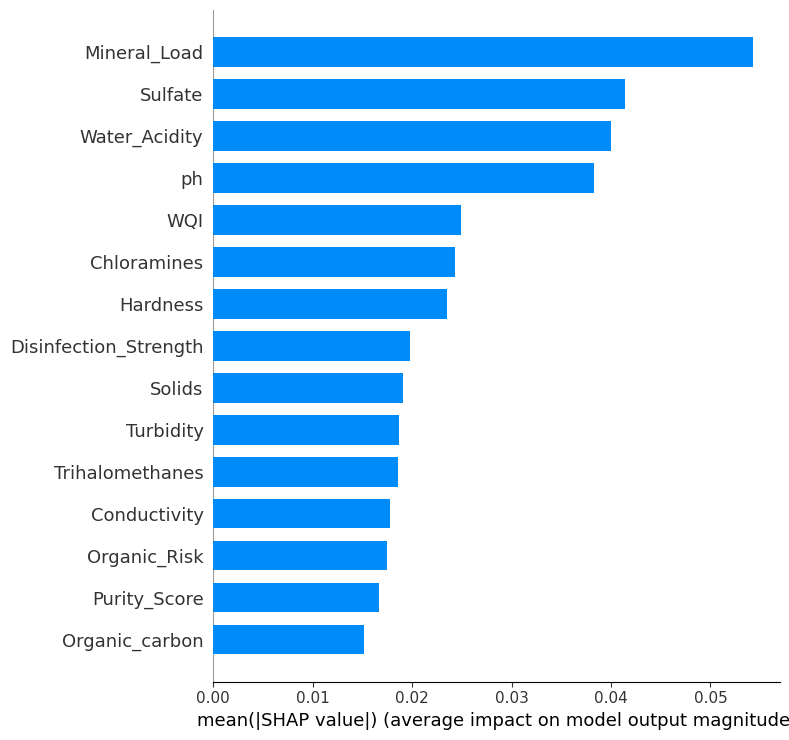

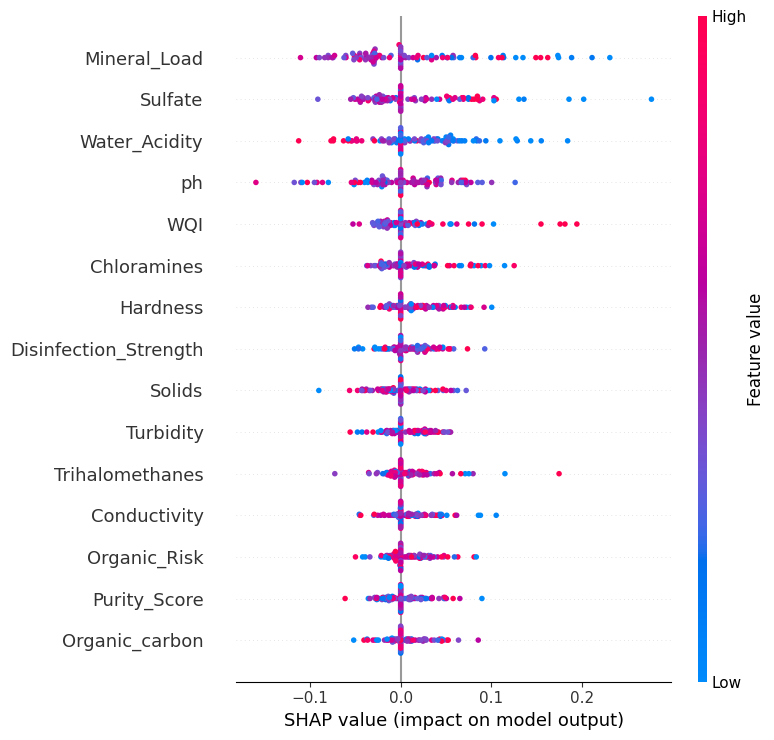

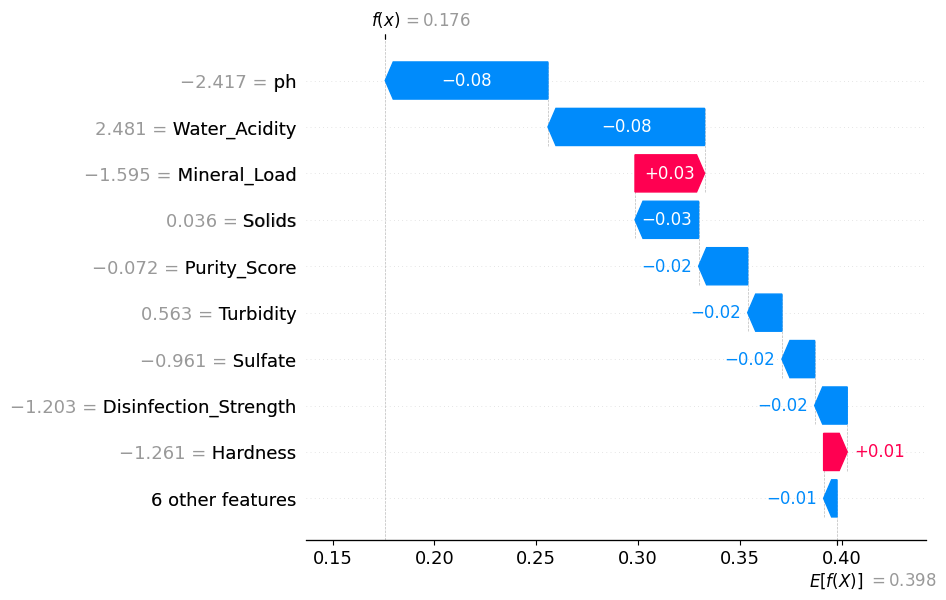


🔬 CHEMICAL INTERPRETATION OF THIS SAMPLE:


🔬 CHEMICAL INTERPRETATION OF THIS SAMPLE:

• ph = -2.42 → suboptimal pH → reduces potability
• Water_Acidity = 2.48 → high acidity → reduces potability
• Mineral_Load = -1.59 → moderate value → good for potability
• Solids = 0.04 → high value → reduces potability
• Purity_Score = -0.07 → unknown effect


In [ ]:
# ============================================
# 📌 FAST SHAP EXPLAINABILITY (Using Calibrated Stacking Model)
# ============================================

import shap
import numpy as np
import matplotlib.pyplot as plt

print("\n🔍 Running FAST SHAP on Calibrated Stacking Model (Top 4 Models)...")

# 1️⃣ Use calibrated stacking model
model = calibrated_model  # calibrated_model from probability calibration

# --------------------------------------------
# ⚡ FAST MODE FIXES
# --------------------------------------------
# Reduce background samples to speed up SHAP
X_background = shap.sample(X_train_df, 30, random_state=42)

# Use only a subset of test samples (first 50)
X_shap = X_test_df.iloc[:100]

# KernelExplainer works with predict_proba for probability output
explainer = shap.KernelExplainer(
    model.predict_proba,
    X_background,
)

# Compute SHAP values for class 1 (potable)
shap_values = explainer.shap_values(X_shap, nsamples=100)   # FAST!!
sv = shap_values[1]  # Class 1 contributions

print("✅ SHAP values computed successfully!")

# ============================================
# 📌 GLOBAL FEATURE IMPORTANCE (BAR PLOT)
# ============================================
shap.summary_plot(sv, X_shap, plot_type="bar")

# ============================================
# 📌 BEESWARM PLOT
# ============================================
shap.summary_plot(sv, X_shap)

# ============================================
# 📌 LOCAL SHAP EXPLANATION FOR ONE SAMPLE
# ============================================
sample_index = 10   # pick any test index
sample = X_shap.iloc[[sample_index]]

shap.waterfall_plot(
    shap.Explanation(
        values=sv[sample_index],
        base_values=explainer.expected_value[1],
        data=sample.values[0],
        feature_names=sample.columns
    )
)

# ============================================
# 📌 CHEMICAL INTERPRETATION (Top 5 features)
# ============================================
sample_row = X_shap.iloc[sample_index]
shap_contribs = sv[sample_index]

top_idx = np.argsort(-np.abs(shap_contribs))[:5]   # Top 5 influential features

print("\n🔬 CHEMICAL INTERPRETATION OF THIS SAMPLE:\n")

def interpret_feature(feature, value):
    if feature == "ph":
        if 6.5 <= value <= 8.5:
            direction = "optimal pH → good for potability"
        else:
            direction = "suboptimal pH → reduces potability"
    elif feature in ["Solids", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"]:
        direction = "high value → reduces potability"
    elif feature in ["Mineral_Load", "Hardness", "Chloramines"]:
        direction = "moderate value → good for potability"
    elif feature == "Water_Acidity":
        direction = "high acidity → reduces potability"
    else:
        direction = "unknown effect"
    return direction

print("\n🔬 CHEMICAL INTERPRETATION OF THIS SAMPLE:\n")
for i in top_idx:
    feature = sample_row.index[i]
    value = sample_row.iloc[i]
    direction = interpret_feature(feature, value)
    print(f"• {feature} = {value:.2f} → {direction}")



In [ ]:
# 💧 Water Quality Recommendation Mapping
# Source references: WHO Guidelines for Drinking-water Quality (4th Ed.),
# US EPA Water Treatment Tech Docs, BIS IS 10500:2012, and related background documents.

WATER_QUALITY_RECOMMENDATIONS = {
    "pH": {
        "threshold_low": 6.5,
        "threshold_high": 8.5,
        "issue_low": "Acidic water - corrosive to pipes and metallic taste.",
        "issue_high": "Alkaline water - scaling and poor taste.",
        "recommendation_low": [
            "Add lime (Ca(OH)₂) or sodium hydroxide to neutralize acidity.",
            "Use pH stabilization units post-treatment."
        ],
        "recommendation_high": [
            "Inject CO₂ or add weak acid to lower pH.",
            "Implement corrosion control after pH adjustment."
        ],
        "source": "WHO: pH in Drinking-water, 4th Ed."
    },

    "Hardness": {
        "threshold_high": 200,  # mg/L as CaCO3
        "issue_high": "High hardness - scaling, taste, and soap inefficiency.",
        "recommendation_high": [
            "Use ion-exchange softener (replace Ca²⁺/Mg²⁺ with Na⁺).",
            "Apply lime-soda softening or use RO for household level."
        ],
        "source": "WHO: Hardness in Drinking-water; BIS IS 10500:2012."
    },

    "TDS": {
        "threshold_high": 500,  # mg/L
        "issue_high": "High dissolved solids - salty taste, scaling, and corrosion.",
        "recommendation_high": [
            "Use reverse osmosis (RO) or electrodialysis to reduce TDS.",
            "Distillation for laboratory-grade or low-volume purification."
        ],
        "source": "WHO: Guidelines for Drinking-water Quality (TDS section)."
    },

    "Chlorine": {
        "threshold_high": 4,  # mg/L free chlorine
        "issue_high": "High chlorine causes bad taste and potential DBP formation.",
        "issue_low": "Low chlorine may lead to microbial contamination.",
        "recommendation_high": [
            "Use activated carbon filters to remove excess chlorine.",
            "Optimize chlorination dose to balance microbial safety."
        ],
        "recommendation_low": [
            "Increase chlorine dose or ensure proper contact time.",
            "Check for organic matter that consumes chlorine."
        ],
        "source": "EPA: Surface Water Treatment Rule, WHO Chlorine Factsheet."
    },

    "Sulfate": {
        "threshold_high": 250,  # mg/L
        "issue_high": "High sulfate causes bitter taste and laxative effect.",
        "recommendation_high": [
            "Use reverse osmosis or distillation.",
            "Apply ion exchange with anion resin to remove sulfate."
        ],
        "source": "WHO: Sulfate in Drinking-water (background doc)."
    },

    "Turbidity": {
        "threshold_high": 1,  # NTU (for treated water)
        "issue_high": "High turbidity reduces disinfection effectiveness.",
        "recommendation_high": [
            "Perform coagulation + flocculation + filtration.",
            "Use sedimentation or pre-filtration for raw water."
        ],
        "source": "EPA: Surface Water Treatment Rule; WHO Turbidity guidance."
    },

    "Organic_Carbon": {
        "threshold_high": 5,  # mg/L TOC (approx guideline)
        "issue_high": "High organic matter promotes DBP formation and microbial growth.",
        "recommendation_high": [
            "Use activated carbon adsorption (GAC/PAC).",
            "Apply ozonation or enhanced coagulation."
        ],
        "source": "WHO: Disinfection By-product Control (THM/TOC)."
    },

    "Nitrate": {
        "threshold_high": 50,  # mg/L as NO3-
        "issue_high": "High nitrate can cause methemoglobinemia (blue baby syndrome).",
        "recommendation_high": [
            "Use ion exchange with anion resin.",
            "Reverse osmosis or biological denitrification for large systems."
        ],
        "source": "WHO: Nitrate and Nitrite in Drinking-water (2022 update)."
    },

    "Fluoride": {
        "threshold_high": 1.5,  # mg/L
        "issue_high": "High fluoride causes dental and skeletal fluorosis.",
        "recommendation_high": [
            "Use activated alumina or bone char adsorption.",
            "Apply reverse osmosis or Nalgonda technique (coagulation defluoridation)."
        ],
        "source": "WHO: Fluoride in Drinking-water (background doc)."
    },

    "Iron": {
        "threshold_high": 0.3,  # mg/L
        "issue_high": "High iron causes metallic taste and reddish stains.",
        "recommendation_high": [
            "Aerate and filter to oxidize and remove Fe²⁺.",
            "Use greensand or oxidation-filtration units."
        ],
        "source": "WHO: Iron in Drinking-water; EPA Iron & Manganese Removal."
    },

    "Manganese": {
        "threshold_high": 0.1,  # mg/L
        "issue_high": "High manganese causes black stains and metallic taste.",
        "recommendation_high": [
            "Oxidation followed by filtration (e.g., greensand filter).",
            "Use reverse osmosis or ion exchange for residual Mn."
        ],
        "source": "WHO: Manganese in Drinking-water (background doc)."
    },

    "Arsenic": {
        "threshold_high": 0.01,  # mg/L
        "issue_high": "Arsenic is carcinogenic and toxic in long-term exposure.",
        "recommendation_high": [
            "Use iron-based adsorptive media or coagulation-filtration.",
            "Apply reverse osmosis or oxidation + filtration (for As(III) removal)."
        ],
        "source": "WHO: Arsenic in Drinking-water; EPA Arsenic Treatment Tech Doc."
    },

    "Lead": {
        "threshold_high": 0.01,  # mg/L
        "issue_high": "Lead causes neurological and developmental issues.",
        "recommendation_high": [
            "Use corrosion control (orthophosphate dosing, pH adjustment).",
            "Replace lead service lines; use certified POU filters."
        ],
        "source": "EPA Lead and Copper Rule (LCR); WHO Lead in Drinking-water."
    },

    "Coliform": {
        "threshold_high": 0,  # any detection = unsafe
        "issue_high": "Presence of coliform/E. coli indicates microbial contamination.",
        "recommendation_high": [
            "Disinfect water with chlorine or UV treatment.",
            "Boil water before use and inspect source contamination."
        ],
        "source": "WHO: Microbiological Aspects of Drinking-water Quality."
    }
}


In [ ]:
# List of actual water features (in order of your dataset columns)
feature_names = [
    "ph", "Hardness", "Solids", "Chloramines", "Sulfate",
    "Conductivity", "Organic_carbon", "Trihalomethanes",
    "Turbidity", "Water_Acidity", "Mineral_Load",
    "Organic_Risk", "Disinfection_Strength", "Purity_Score", "WQI"
]


import numpy as np


def get_recommendations_threshold_based(sample_scaled, shap_values_sample=None, top_n=5):
    """
    Generate water treatment recommendations based on thresholds.
    SHAP values are optional, used only for showing ↑/↓ direction.

    Args:
        sample_scaled: 1D numpy array (scaled sample)
        shap_values_sample: 1D numpy array of SHAP values for the sample (optional)
        top_n: number of top SHAP features to display direction for (optional)

    Returns:
        List of formatted recommendation strings
    """
    # Convert scaled sample back to original units
    sample_real = scaler.inverse_transform(sample_scaled.reshape(1, -1))[0]
    rec_list = []

    # Iterate through all features
    for i, feature in enumerate(feature_names):
        value = sample_real[i]
        rules = WATER_QUALITY_RECOMMENDATIONS.get(feature, None)
        if not rules:
            continue

        recs = []
        # Check thresholds
        if "threshold_low" in rules and value < rules["threshold_low"]:
            recs.extend(rules.get("recommendation_low", []))
        if "threshold_high" in rules and value > rules["threshold_high"]:
            recs.extend(rules.get("recommendation_high", []))

        if recs:
            # Include direction if SHAP values provided
            if shap_values_sample is not None:
                contrib = shap_values_sample[i]
                direction = "↑ increases potability" if contrib > 0 else "↓ decreases potability"
            else:
                direction = ""
            merged_recs = " or ".join(recs)
            rec_list.append(
                f"{feature}={value:.2f} {direction}: {merged_recs} (Source: {rules['source']})"
            )

    # Fallback if no thresholds crossed
    if not rec_list:
        rec_list.append(
            "All features within safe thresholds; standard treatment recommended (filtration, chlorination, RO)."
        )

    return rec_list





# ============================================
# 📌 Example Usage
# ============================================

sample_index = 10
sample_scaled = X_test_over[sample_index]
shap_values_sample = sv[sample_index]
# Use calibrated model to get probability
prob = calibrated_model.predict_proba(sample_scaled.reshape(1, -1))[0,1]
pred = "Potable" if prob >= 0.5 else "Not Potable"

# Use threshold-based recommendations (with optional SHAP for ↑/↓)
recommendations = get_recommendations_threshold_based(sample_scaled, shap_values_sample, top_n=5)

# Display
print(f"\n💧 Water Sample Prediction: {pred} (Probability: {prob:.2f})")
print("⚠ Recommended Water Treatment Actions:\n")
for rec in recommendations:
    print("•", rec)








💧 Water Sample Prediction: Not Potable (Probability: 0.18)
⚠ Recommended Water Treatment Actions:

• Sulfate=299.81 ↓ decreases potability: Use reverse osmosis or distillation. or Apply ion exchange with anion resin to remove sulfate. (Source: WHO: Sulfate in Drinking-water (background doc).)
• Turbidity=4.39 ↓ decreases potability: Perform coagulation + flocculation + filtration. or Use sedimentation or pre-filtration for raw water. (Source: EPA: Surface Water Treatment Rule; WHO Turbidity guidance.)


In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# 1️⃣ Prediction function for custom water sample
# ============================================================
def predict_custom_water_threshold(sample_dict):
    """
    Input: sample_dict -> dict of your water features (raw values)
    Returns: prediction, probability, recommendations, WQI
    """

    # 1️⃣ Compute engineered features (same as preprocessing)
    sample_dict['Water_Acidity'] = abs(sample_dict['ph'] - 7)
    sample_dict['Mineral_Load'] = sample_dict['Hardness'] + sample_dict['Solids'] + sample_dict['Sulfate']
    sample_dict['Organic_Risk'] = sample_dict['Organic_carbon'] + sample_dict['Trihalomethanes']
    sample_dict['Disinfection_Strength'] = sample_dict['Chloramines'] + sample_dict['Turbidity']
    sample_dict['Purity_Score'] = 1 / (sample_dict['Solids'] + 1)

    # 2️⃣ Compute WQI using preprocessing function
    def compute_Qi(param, value):
        Si = STANDARDS[param]
        Ii = IDEAL[param]
        if pd.isna(value):
            return np.nan
        Qi = ((value - Ii) / (Si - Ii)) * 100
        return max(Qi, 0)

    def compute_WQI_row(sample_dict):
        return sum(compute_Qi(param, sample_dict[param]) * WEIGHTS[param] for param in WEIGHTS)

    sample_dict["WQI"] = compute_WQI_row(sample_dict)

    # 3️⃣ Arrange features in the same order as model expects
    features_ordered = [
        "ph", "Hardness", "Solids", "Chloramines", "Sulfate",
        "Conductivity", "Organic_carbon", "Trihalomethanes",
        "Turbidity", "Water_Acidity", "Mineral_Load",
        "Organic_Risk", "Disinfection_Strength", "Purity_Score", "WQI"
    ]

    sample_array = np.array([sample_dict[f] for f in features_ordered]).reshape(1, -1)

    # 4️⃣ Scale using fitted scaler
    sample_scaled = scaler.transform(sample_array)

    # 5️⃣ Predict probability with calibrated model
    prob = calibrated_model.predict_proba(sample_scaled)[:, 1][0]
    pred = "Potable" if prob >= 0.5 else "Not Potable"

    # 6️⃣ Compute SHAP values (optional for ↑/↓ direction)
    shap_values_sample = explainer.shap_values(sample_scaled)[1][0]  # class 1

    # 7️⃣ Generate threshold-based recommendations (all features)
    recommendations = get_recommendations_threshold_based(
        sample_scaled[0],
        shap_values_sample=shap_values_sample  # optional
    )

    return pred, prob, recommendations, sample_dict["WQI"]


# ============================================================
# 2️⃣ Example usage with your own values
# ============================================================
my_sample = {
    "ph": 5.8,
    "Hardness": 180,
    "Solids": 400,
    "Chloramines": 6,
    "Sulfate": 299,
    "Conductivity": 500,
    "Organic_carbon": 5,
    "Trihalomethanes": 0.05,
    "Turbidity": 4.39
}

pred, prob, recs, wqi = predict_custom_water_threshold(my_sample)

print(f"\n💧 Water Sample Prediction: {pred} (Probability: {prob:.2f})")
print(f"📊 WQI: {wqi:.2f}\n")
print("⚠ Recommended Water Treatment Actions:\n")
for r in recs:
    print("•", r)


  0%|          | 0/1 [00:00<?, ?it/s]


💧 Water Sample Prediction: Not Potable (Probability: 0.31)
📊 WQI: 124.51

⚠ Recommended Water Treatment Actions:

• Sulfate=299.00 ↓ decreases potability: Use reverse osmosis or distillation. or Apply ion exchange with anion resin to remove sulfate. (Source: WHO: Sulfate in Drinking-water (background doc).)
• Turbidity=4.39 ↓ decreases potability: Perform coagulation + flocculation + filtration. or Use sedimentation or pre-filtration for raw water. (Source: EPA: Surface Water Treatment Rule; WHO Turbidity guidance.)


In [ ]:
import pickle

# Objects to save
save_dict = {
    "calibrated_model": calibrated_model,
    "scaler": scaler,
    "explainer": explainer,
    "get_recommendations": get_recommendations_threshold_based,
    "feature_names": feature_names,
    "STANDARDS": STANDARDS,
    "IDEAL": IDEAL,
    "WEIGHTS": WEIGHTS
    # "WATER_QUALITY_RECOMMENDATIONS": WATER_QUALITY_RECOMMENDATIONS  # include if defined
}

# Save all in one pickle
with open("waterrrrr_potability_pipeline.pkl", "wb") as f:
    pickle.dump(save_dict, f)

print("✅ Pipeline saved successfully!")


✅ Pipeline saved successfully!


In [ ]:
import pickle

# Objects to save
save_dict = {
    "calibrated_model": calibrated_model,    # your calibrated model
    "scaler": scaler,                        # fitted StandardScaler
    "explainer": explainer,                  # SHAP explainer
    "get_recommendations": get_recommendations_corrected,  # recommendation function
    "feature_names": feature_names           # feature order
}

# Save to pickle
with open("123water_potability_pipeline.pkl", "wb") as f:
    pickle.dump(save_dict, f)

print("✅ Pipeline saved successfully!")


✅ Pipeline saved successfully!


In [ ]:
import pickle

# 1️⃣ Objects to save
objects_to_save = {
    "calibrated_model": calibrated_model,   # your CalibratedClassifierCV
    "scaler": scaler,                       # StandardScaler used to scale features
    "shap_explainer": explainer,            # SHAP KernelExplainer
    "feature_names": feature_names,         # list of features
    "water_recommendations": WATER_QUALITY_RECOMMENDATIONS  # recommendation mapping
}

# 2️⃣ Save to a single pickle file
with open("water_quality_pipeline_final.pkl", "wb") as f:
    pickle.dump(objects_to_save, f)

print("✅ All objects saved successfully to 'water_quality_pipeline.pkl'")

# ====================================
# 3️⃣ Example: How to load later
# ====================================
# with open("water_quality_pipeline.pkl", "rb") as f:
#     saved_objects = pickle.load(f)
#
# calibrated_model = saved_objects["calibrated_model"]
# scaler = saved_objects["scaler"]
# explainer = saved_objects["shap_explainer"]
# feature_names = saved_objects["feature_names"]
# WATER_QUALITY_RECOMMENDATIONS = saved_objects["water_recommendations"]


✅ All objects saved successfully to 'water_quality_pipeline.pkl'


In [ ]:
import joblib
import pickle

# Prepare a dict containing all your objects
pipeline_objects = {
    "stack_model": stack_model,
    "calibrated_model": calibrated_model,
    "scaler": scaler,
    "feature_names": feature_names,
    "recommendation_mapping": WATER_QUALITY_RECOMMENDATIONS,
}

# Save everything in one .pkl
with open("water_quality_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline_objects, f)

print("✅ Entire pipeline saved to water_quality_pipeline.pkl")


✅ Entire pipeline saved to water_quality_pipeline.pkl


In [ ]:
# Models
joblib.dump(stack_model, "stack_model.pkl")
joblib.dump(calibrated_model, "calibrated_model.pkl")

# Scaler
joblib.dump(scaler, "scaler.pkl")

# Feature names & recommendation dict
with open("feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)

with open("recommendations.pkl", "wb") as f:
    pickle.dump(WATER_QUALITY_RECOMMENDATIONS, f)
